In [1]:
# Load common utility functions from a separate Julia script
include("common_functions.jl")

# Import support for LaTeX-style strings for plotting and labeling
using LaTeXStrings

In [2]:
# Define a custom observer for DMRG convergence based on energy threshold and Lindbladian expectation
mutable struct DemoObserver <: AbstractObserver
    energy_tol::Float64               # Energy convergence threshold
    lind::MPO                         # Lindbladian operator for checking expectation value
    elist::Vector{ComplexF64}        # List of energies recorded at each sweep
    last_energy::ComplexF64          # Energy at previous sweep
    sweep_count::Int64               # Number of consecutive sweeps within threshold

    # Constructor
    DemoObserver(energy_tol, lind) = new(energy_tol, lind, ComplexF64[], -1.0, 0)
end

# Define the stopping criterion for DMRG sweeps
function ITensorMPS.checkdone!(o::DemoObserver; kwargs...)
    psi     = kwargs[:psi]           # Current MPS
    sw      = kwargs[:sweep]         # Current sweep number
    energy  = kwargs[:energy]        # Current energy

    # Optional: Uncomment to monitor true expectation value
    # println("True energy = ", inner(psi', o.lind, psi) / norm(psi)^2)

    # Track convergence: increase counter if energy change is below threshold
    if abs(energy - o.last_energy) < 1e-8
        o.sweep_count += 1
    else
        o.sweep_count = 0
    end

    # Check if convergence criteria are met
    if (abs(real(energy)) < o.energy_tol) || (o.sweep_count >= 4)
        println("Observer-based stopping DMRG after sweep $sw")
        return true
    end

    # Update observer state
    push!(o.elist, energy)
    o.last_energy = energy

    return false
end

### Function to generate the Lindbladian

In [6]:
"""
    get_lind(sites; coeff, pbc=false, bc_weak=false, bc_strong=false)

Construct the Lindbladian MPO given a set of coefficients and lattice geometry.

# Arguments
- `sites`: The site indices (e.g., from `siteinds("S=1/2", N)`).
- `coeff`: A list of coefficients controlling which terms are added (default includes standard L0/L1/L2).
- `pbc`: Periodic boundary conditions (currently unused).
- `bc_weak`, `bc_strong`: Flags for adding special boundary terms (unused here but placeholders for future use).

# Returns
- `lind`: The constructed Lindbladian as an MPO.
"""
function get_lind(sites, coeff = [1,0,0,0,0,0,1,1,0,0,0,0], pbc = false, bc_weak = false, bc_strong = false)
    # Unpack coefficients
    CL0, CL3, CLx_odd, CLx_even, CLz_odd, CLz_even,
    CL1, CL2, CL0_old, CLzz, CL0_left,
    CL0_dual, CL1_dual, CL2_dual, CL_pert = coeff

    N = length(sites) ÷ 2  # Assumes 2-site unit cells
    os = OpSum()

    ## Single-site Lindblad terms (even sites)
    for i in 2:2:N-1
        os += L0_minus(i, CL0)
        os += L0_dual(i, CL0_dual)
    end

    ## Single-site Lindblad terms (odd sites)
    for i in 1:2:N
        os += L1(i, CL1)
        os += L1_dual(i, CL1_dual)
    end

    ## L2 terms (paper-specific)
    for i in 3:2:N-1
        os += L2_paper(i, proj, CL2)
        os += L2_paper_dual(i, proj, CL2_dual)
    end

    # --------------------------------------------------------------------
    # Below are alternative/additional interaction terms you can enable
    # by uncommenting. Organized by category.
    # --------------------------------------------------------------------

    ## Two-site interaction terms
    # for i in 2:2:N-1
    #     os += L_two_site(i, pmp, pmp, CL_pert)
    # end

    ## Lzz or Lxx interactions
    # for i in 2:2:N-1
    #     os += Lzz(i, CL_pert)
    # end
    # for i in 1:N-1
    #     os += Lxx_consecutive(i, CL_pert)
    # end

    ## Local fields (optional)
    # for i in 1:2:N
    #     os += Hx(i, CL_pert)
    # end

    ## Hzz interactions
    # for i in 2:2:N-2
    #     os += Hzz(i, CL_pert)
    # end

    ## Generic two-site Hamiltonians
    # for i in 1:2:N-2
    #     os += H_two_site(i, CL_pert, Z, Z)
    # end

    ## Alternating projectors or Pauli strings
    # for i in 1:2:N-2
    #     os += L_two_site(i, p00, p01, CL_pert)
    #     os += L_two_site(i, p11, p10, CL_pert)
    # end

    ## Miscellaneous two-site Pauli terms
    # for i in 1:4:N-3
    #     os += L_two_site(i, Id, Z, 1.1 * CL_pert)
    #     os += L_two_site(i, Z, Id, 2.3 * CL_pert)
    #     os += L_two_site(i, X, X, 4.3 * CL_pert)
    #     os += L_two_site(i, X, Y, 1.3 * CL_pert)
    #     os += L_two_site(i, Y, X, 0.65 * CL_pert)
    #     os += L_two_site(i, Y, Y, 0.19 * CL_pert)
    #     os += L_two_site(i, Z, Z, 2.1 * CL_pert)
    # end

    ## Build the Lindbladian MPO
    lind = MPO(os, sites)

    println("Maximum bond dimension of Lindbladian = ", maximum(linkdims(lind)))
    return lind
end

get_lind

### Main DMRG function to determine steady state

In [7]:
"""
    main_lindbladian(N; λ=0.0, h=0.0)

Run DMRG to find the steady state of a Lindbladian with adjustable coupling (λ) and perturbation (h).

# Arguments
- `N`: Number of *unit cells* (physical sites = 2N).
- `λ`: Dual sector coupling (default = 0).
- `h`: Perturbation strength (default = 0).

# Returns
- `energy_list`: List of energies of steady states found.
- `state_list`: Corresponding MPS wavefunctions.
- `var_list`: Energy variances.
- `sites`: Site indices.
- `lind`: Lindbladian MPO.
"""
function main_lindbladian(N, λ = 0.0, h = 0.0)

    # -------------------------
    # DMRG and Lindbladian Setup
    # -------------------------
    nstates = 1                         # Number of steady states to find
    weight = 10                         # Weight parameter for DMRG
    energy_stop_tol = 3e-5              # Stopping tolerance for energy
    krylovdim = 20                      # Dimension of Krylov space
    nsweeps = 20                        # Number of DMRG sweeps
    maxdim = [10,30,50,100,100,100,100,200,200]  # Bond dimension schedule
    cutoff = [1e-12]                    # Truncation cutoff
    noise = [0.1, 0.01, 1e-6, 1e-7, 1e-8, 1e-9, 1e-9, 1e-10, 1e-10, 1e-12]  # Noise schedule

    # -------------------------
    # Define Lindblad Coefficients
    # -------------------------
    CL0 = 1.0 - λ
    CL1 = 1.0 - λ
    CL2 = 1.0 - λ
    CL0_dual = λ
    CL1_dual = λ
    CL2_dual = λ
    CL_pert = h

    # Other coefficients (unused but included for compatibility)
    CL3 = CLx_odd = CLx_even = CLz_odd = CLz_even = 0.0
    CL0_old = CLzz = CL0_left = 0.0

    coeff = [CL0, CL3, CLx_odd, CLx_even, CLz_odd, CLz_even,
             CL1, CL2, CL0_old, CLzz, CL0_left,
             CL0_dual, CL1_dual, CL2_dual, CL_pert]

    println("N = $N")
    println("coeff = ", coeff)

    # -------------------------
    # Construct Lindbladian MPO
    # -------------------------
    sites = si(2N)
    pbc = false
    twisted_weak = false
    twisted_strong = false
    lind = get_lind(sites, coeff, pbc, twisted_weak, twisted_strong)
    obs = [DemoObserver(energy_stop_tol, -lind) for _ in 1:nstates]

    # -------------------------
    # Main DMRG Loop
    # -------------------------
    state_list = []
    energy_list = []
    var_list = []

    for i in 1:nstates
        println("Running DMRG for state $i")
        initial_state::MPS = randomMPS(sites, 6)

        if !isempty(state_list)
            # With warm start
            energy, psi = dmrg(-lind, Vector{MPS}(state_list), initial_state;
                observer=obs[i], nsweeps, ishermitian=false,
                eigsolve_krylovdim=krylovdim, maxdim=maxdim,
                noise=noise, cutoff=cutoff, weight=weight)
        else
            # Cold start
            energy, psi = dmrg(-lind, initial_state;
                observer=obs[i], nsweeps, ishermitian=false,
                eigsolve_krylovdim=krylovdim, maxdim=maxdim,
                noise=noise, cutoff=cutoff)
        end

        # -------------------------
        # Projection (Optional)
        # -------------------------
        projection = false
        if projection
            projected_psi = project(psi)
            println("Projecting to subspace of size = ", length(projected_psi))

            for state in projected_psi
                en = inner(state', -lind, state)
                var = norm(apply(lind, state))^2 - abs(en)^2
                if imag(var) > 1e-10
                    println("Warning: Imaginary variance")
                end
                if real(var) < 0.0
                    println("Warning: Negative variance")
                end
                var = abs(var)
                push!(state_list, state)
                push!(energy_list, en)
                push!(var_list, var)
                print(var, ", ")
            end
        else
            # -------------------------
            # Save Single Unprojected State
            # -------------------------
            state = psi
            en = inner(state', -lind, state)
            var = norm(apply(lind, state))^2 - abs(en)^2

            if imag(var) > 1e-10
                println("Warning: Imaginary variance")
            end
            if real(var) < 0.0
                println("Warning: Negative variance")
            end

            push!(state_list, state)
            push!(energy_list, en)
            push!(var_list, abs(var))

            println("Saving MPS")
            filename = "./data/saved_MPS/paper_unprojected_lambda$(N), $(λ).h5"
            f = h5open(filename, "w")
            write(f, "psi", state)
            close(f)
        end
    end

    # -------------------------
    # Return results
    # -------------------------
    println("Final energy list: ", energy_list)
    return energy_list, state_list, var_list, sites, lind
end

main_lindbladian

In [8]:
# ----------------------------------------
# Parameter Sweep for Lindbladian DMRG
# ----------------------------------------

# Initialize containers for results
energy_super_list = []     # Energies from each run
state_super_list = []      # Corresponding MPS states
var_super_list   = []      # Variances
deg_super_list   = []      # Degeneracy (low-energy states)

λ_super_list     = []      # Track λ values used
N_super_list     = []      # Track N values used
pert_super_list  = []      # Track perturbation strengths

# ----------------------------------------
# Define parameter grids
# ----------------------------------------
Nlist    = [400]                   # List of system sizes
# λlist    = 0.0:0.1:1.0            # Range of λ values (coupling strength)
# Uncomment above to use the full range of λ values
λlist = [0.0,0.1]
pert     = 0.0                    # Perturbation strength
pert_list = [pert]               # You can expand this if needed

# ----------------------------------------
# Run over all combinations of parameters
# ----------------------------------------
for N in Nlist
    for λ in λlist
        println("\nRunning DMRG with λ = $λ, N = $N")

        # Call main DMRG routine
        energy_list, state_list, var_list, sites, lind = main_lindbladian(N, λ, pert)

        # Count number of nearly-zero energy eigenvalues (degeneracy)
        deg = sum(abs.(energy_list) .< 1e-5)
        push!(deg_super_list, deg)

        println("System size N = $N")
        println("Variances = ", var_list)

        # Store results
        push!(energy_super_list, energy_list)
        push!(state_super_list, state_list)
        push!(var_super_list, var_list)
        push!(λ_super_list, λ)
        push!(pert_super_list, pert)
        push!(N_super_list, N)

        # Optional: Save interim results to disk
        # save("./data/temp/super_run_data.jld", "energy_super_list", energy_super_list)
    end
end


Running DMRG with λ = 0.0, N = 400
N = 400
coeff = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Maximum bond dimension of Lindbladian = 7
Running DMRG for state 1
After sweep 1 energy=-0.009108235767841769 + 0.0006671177006435567im  maxlinkdim=10 maxerr=1.69E-03 time=30.032
After sweep 2 energy=1.8126880652977343e-13 + 3.4119133947463876e-15im  maxlinkdim=8 maxerr=1.02E-15 time=3.193
Observer-based stopping DMRG after sweep 2
Saving MPS
Final energy list: Any[1.7033596325731452e-13 + 5.178431598102326e-15im]
System size N = 400
Variances = Any[5.171808860985372e-27]

Running DMRG with λ = 0.1, N = 400
N = 400
coeff = [0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 0.9, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.0]
Maximum bond dimension of Lindbladian = 8
Running DMRG for state 1
After sweep 1 energy=-0.0011594739122913712 + 0.0009714149641841809im  maxlinkdim=10 maxerr=6.63E-03 time=9.562
After sweep 2 energy=-1.6672471028350112e-5 - 1.7437367299454844e-8im  maxlinkdim=30 max

In [9]:
# ------------------------------------------------
# Load Saved MPS States for Various λ Values
# ------------------------------------------------

N = 400  # System size
state_list = []  # Store unprojected MPS states
# strong_state_list = []  # Optionally store projected versions

# Define the list of λ values to process
λlist = [0.0, 0.1]
λlist = 0.0:0.1:1.0  # Uncomment for full range

for λ in λlist
    # Construct the file path for the saved MPS
    filename = "./data/saved_MPS/paper_unprojected_lambda$(N), $(λ).h5"

    # Load the MPS from disk
    read_state = load_state(filename)

    # Save to list
    push!(state_list, read_state)

    # Optional: project to symmetric subspace
    # push!(strong_state_list, plusplus_project(read_state))
end

# String correlators

In [10]:
# ------------------------------------------------
# Project loaded MPS states into symmetric subspace
# ------------------------------------------------

strong_state_list = [plusplus_project(state) for state in state_list]
;

### Calculate correlators

In [33]:
# ------------------------------------------------------
# Compute correlators from projected MPS (strong states)
# ------------------------------------------------------

# Set the range for measurement
string_start_pt = 100 + 1       # Starting index for string operators
string_end_pt   = string_start_pt + 60  # Ending index for string operators

start_pt = string_start_pt
end_pt   = string_end_pt

# Initialize storage arrays
y1_strong_nontrivial = []
y1_strong_trivial = []

y2_strong_nontrivial = []
y2_strong_trivial = []

y2_weak_nontrivial = []
y2_weak_trivial = []

xlist = []  # Stores distances (m - start_pt)

# Loop over all projected states
for i in 1:length(strong_state_list)
    state = strong_state_list[i]

    # Per-state storage
    s1_strong_nontrivial = []
    s1_strong_trivial = []

    s2_strong_nontrivial = []
    s2_strong_trivial = []

    s2_weak_nontrivial = []
    s2_weak_trivial = []

    x = []

    # Get site indices and prepare reference state ψ
    s = siteinds(state)
    ψ = get_ψid(s)  # identity operator in doubled Hilbert space
    den = inner(ψ, state)  # normalization factor

    if abs(den) < 1e-5
        println("Warning: trace is very small for state $i")
    end

    # Loop over string lengths in steps of 4
    for m in start_pt:4:end_pt
        # Nontrivial strong and weak string operators
        push!(s1_strong_nontrivial, strong_nontrivial_1copy_correlator(state, start_pt, m, den))
        push!(s2_strong_nontrivial, strong_nontrivial_2copy_correlator(state, start_pt, m, true))
        push!(s2_weak_nontrivial, weak_nontrivial_2copy_correlator(state, start_pt + 1, m + 1, true))

        # Trivial strong and weak string operators
        push!(s1_strong_trivial, strong_trivial_1copy_correlator(state, start_pt, m, den))
        push!(s2_strong_trivial, strong_trivial_2copy_correlator(state, start_pt, m, true))
        push!(s2_weak_trivial, weak_trivial_2copy_correlator(state, start_pt + 1, m + 1, true))

        push!(x, m - start_pt)
    end

    # Append to global lists
    push!(y1_strong_nontrivial, s1_strong_nontrivial)
    push!(y2_strong_nontrivial, s2_strong_nontrivial)
    push!(y2_weak_nontrivial, s2_weak_nontrivial)

    push!(y1_strong_trivial, s1_strong_trivial)
    push!(y2_strong_trivial, s2_strong_trivial)
    push!(y2_weak_trivial, s2_weak_trivial)

    push!(xlist, x)
    println("done with state $i")
end

done with state 1
done with state 2
done with state 3
done with state 4
done with state 5
done with state 6
done with state 7
done with state 8
done with state 9
done with state 10
done with state 11


### Plot correlators

In [34]:
# ------------------------------------------------------------
# Define and filter valid marker shapes supported by Plots.jl
# ------------------------------------------------------------

# Get list of valid marker symbols
markers = filter(m -> m in Plots.supported_markers(), Plots._shape_keys)

# Define a custom subset of marker shapes for reuse
mshapes = [
    :circle, 
    :rect, 
    :pentagon, 
    :xcross, 
    :diamond,  
    :star5,
    :star4, 
    :rtriangle, 
    :cross
]

# ------------------------------------------------------------
# Set global default plotting style using `default(...)`
# ------------------------------------------------------------

default(
    xformatter = :latex,
    yformatter = :latex,
    left_margin = 1Plots.mm,
    legend = :right,
    framestyle = :box,
    size = 1.6 .* (350, 250),
    xminorticks = 4,
    yminorticks = 4,
    xticks = 3,
    yticks = 4,
    xtickfontsize = 18,
    ytickfontsize = 18,
    xguidefontsize = 18,
    yguidefontsize = 18,
    legendfontsize = 10,
)

"""
    annotatewithbox!(fig, text, x, y, Δx, [Δy]; kwargs...)

Add an annotation `text` to the plot `fig` at position `(x, y)` with a white rectangular background
of width `Δx` and height `Δy` (defaults to square if `Δy` is omitted).

# Arguments
- `fig::Plots.Plot`: the plot object to annotate
- `text::Plots.PlotText`: the annotation text (created using `text(...)`)
- `x, y::Real`: coordinates for the annotation and background box
- `Δx::Real`: width of the background rectangle
- `Δy::Real`: height of the background rectangle (optional; defaults to `Δx`)
- `kwargs`: any additional keyword arguments for styling the rectangle

# Returns
- The modified plot `fig` with the annotation and background box added
"""
function annotatewithbox!(
    fig::Plots.Plot,
    text::Plots.PlotText,
    x::Real, y::Real, Δx::Real, Δy::Real = Δx;
    kwargs...
)
    # Create a rectangle shape centered at origin
    box = Plots.Shape(:rect)

    # Scale it to desired size
    Plots.scale!(box, Δx, Δy)

    # Move it to the desired location (x, y)
    Plots.translate!(box, x, y)

    # Plot the box with white fill and black border (overridable via kwargs)
    Plots.plot!(fig, box, c = :white, linestroke = :black, label = false; kwargs...)

    # Add the text annotation
    Plots.annotate!(fig, x, y, text)

    return fig
end

annotatewithbox!

In [46]:
mshapes =  [:circle, :rect, :star5, :diamond, :hexagon, :utriangle, :dtriangle, :rtriangle, :ltriangle, :pentagon, :heptagon, :octagon, :star4, :star6, :star7, :star8, :vline, :hline, :+, :x];

clrs = [1, 9, 8, 4, 5, 6, 14, 1, 7,10,12,13]
plet =palette(:auto)[clrs] 
palette(:auto)[clrs]


### CI^S correlator

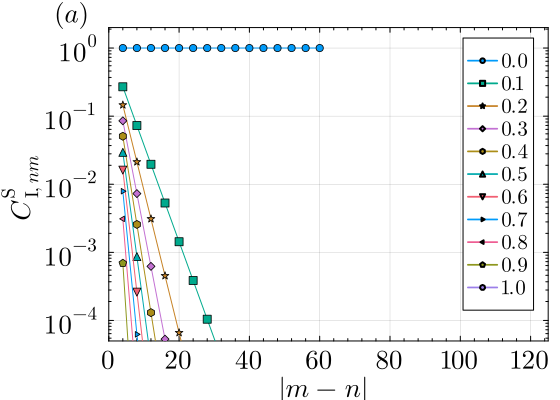

In [47]:
# Axis labels in LaTeX formatting
ylbl = "\$C_{\\textrm{I}, nm}^{\\textrm{S}}\$"
xlbl = "\$|m - n|\$"

# Create the plot object `p1`
p1 = plot(
    top_margin = 5Plots.mm,
    bottom_margin = -0.6Plots.mm,
    left_margin = 1.1Plots.mm,
    right_margin = 1.0Plots.mm,
    xlabel = xlbl,
    ylabel = ylbl,
    xformatter = :latex,
    yformatter = :latex,
    yaxis = :log,
    legend = :topright,
    framestyle = :box,
    xticks = 2 .* [0, 10, 20, 30, 40, 50, 60],
    yticks = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    xminorticks = 5,
    yminorticks = 10,
    xtickfontsize = 18,
    ytickfontsize = 18,
    xguidefontsize = 18,
    yguidefontsize = 18,
    legendfontsize = 14
)


# Plot data for each λ value
for i in 1:length(strong_state_list)
    λ = λlist[i]
    lbl = "\$$λ\$"  # LaTeX-style legend label
    plot!(
        p1,
        xlist[i][2:end],
        abs.(y1_strong_nontrivial[i])[2:end],
        label = lbl,
        markershape = mshapes[i],
        c = plet[i]
    )
end

# Add subplot label
annotate!(p1, -10, 3, text(L"(a)", 18), :black)

# Set plot range
plot!(p1, ylim = (5e-5, 2), xlim = (0, 125))

# Save or display the plot
savefig(p1, "./images/cs1.pdf")
display(p1)

### CII^S correlator

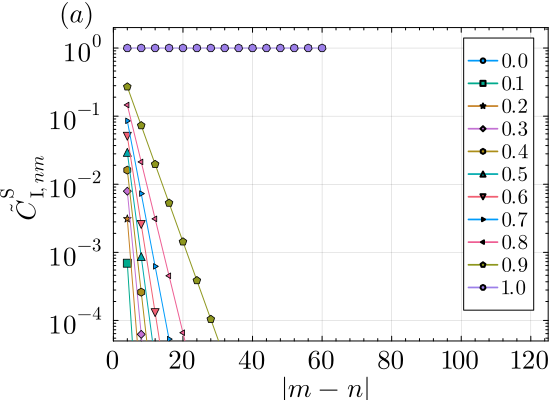

In [48]:
# Axis labels in LaTeX format
ylbl = "\$\\tilde{C}_{\\textrm{I}, nm}^{\\textrm{S}}\$"
xlbl = "\$|m - n|\$"

# Initialize the plot
p1 = plot(
    top_margin = 5Plots.mm,
    bottom_margin = -0.6Plots.mm,
    left_margin = 1.1Plots.mm,
    right_margin = 1.0Plots.mm,
    xlabel = xlbl,
    ylabel = ylbl,
    xformatter = :latex,
    yformatter = :latex,
    yaxis = :log,
    legend = :topright,
    framestyle = :box,
    xticks = 2 .* [0, 10, 20, 30, 40, 50, 60],
    yticks = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    xminorticks = 5,
    yminorticks = 10,
    xtickfontsize = 18,
    ytickfontsize = 18,
    xguidefontsize = 18,
    yguidefontsize = 18,
    legendfontsize = 14
)

# Plot trivial sector 1-copy correlator for each λ
for i in 1:length(strong_state_list)
    λ = λlist[i]
    lbl = "\$$λ\$"
    plot!(
        p1,
        xlist[i][2:end],
        abs.(y1_strong_trivial[i])[2:end],
        label = lbl,
        markershape = mshapes[i],
        c = plet[i]
    )
end

# Add subplot label
annotate!(p1, -10, 3, text(L"(a)", 18), :black)

# Axis limits
plot!(p1, ylim = (5e-5, 2), xlim = (0, 125))

# Save or display
savefig(p1, "./images/cs2.pdf")
display(p1)

### CII^W correlator

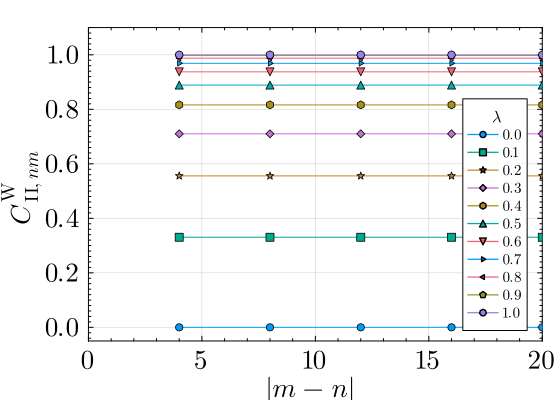

In [49]:
# Axis labels in LaTeX format
ylbl = "\$C_{\\textrm{II}, nm}^{\\textrm{W}}\$"
xlbl = "\$|m - n|\$"

# Initialize plot for weak sector, 2-copy trivial correlator
p2 = plot(
    top_margin = 5Plots.mm,
    bottom_margin = -0.6Plots.mm,
    left_margin = 1.1Plots.mm,
    right_margin = 2.5Plots.mm,
    xlabel = xlbl,
    ylabel = ylbl,
    legendtitle = L"\lambda",
    xformatter = :latex,
    yformatter = :latex,
    legend = :bottomright,
    framestyle = :box,
    xticks = [0, 5, 10, 15, 20],
    yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    xminorticks = 5,
    yminorticks = 10,
    xtickfontsize = 18,
    ytickfontsize = 18,
    xguidefontsize = 18,
    yguidefontsize = 18,
    legendfontsize = 10
)

# Marker shapes
mshapes =  [:circle, :rect, :star5, :diamond, :hexagon, :utriangle, :dtriangle, :rtriangle, :ltriangle, :pentagon, :heptagon, :octagon, :star4, :star6, :star7, :star8, :vline, :hline, :+, :x];


# Plot data
for i in 1:length(strong_state_list)
    λ = λlist[i]
    lbl = "\$$λ\$"
    plot!(
        p2,
        xlist[i][2:end],
        abs.(y2_weak_trivial[i])[2:end],
        label = lbl,
        markershape = mshapes[i],
        c = plet[i]
    )
end

# Subfigure label
annotate!(p2, -10, 1.035, text(L"(c)", 18), :black)

# Axis limits
plot!(p2, ylim = (-0.05, 1.1), xlim = (0, 20))

# Save or display
savefig(p2, "./images/cw2.pdf")
display(p2)

# Connected correlators

In [50]:
# Set the interval for computing correlators
start_pt = 90
end_pt = start_pt + 20  # You can also use: Nlist[1] - start_pt + 2

# Initialize containers for distances and correlator data
distance = []
ZZ1 = []      # One-copy ⟨Z_i Z_j⟩
ZZ2 = []      # Two-copy ⟨Z_i Z_j⟩
ZZZZ = []     # Four-point ⟨Z_i Z_j Z_k Z_l⟩

# Loop over the list of projected strong states
for j in 1:length(strong_state_list)
    psi = strong_state_list[j]

    # Temporary storage for correlator values
    datazz1 = []
    datazz2 = []
    datazzzz = []
    dist = []

    # Compute correlators from start_pt to end_pt at step size 2
    for i in start_pt:2:end_pt
        push!(datazz1, ZZ_corr_1copy(psi, start_pt, i, Z))  # 1-copy Z_i Z_j
        push!(datazz2, ZZ_corr(psi, start_pt, i, Z))        # 2-copy Z_i Z_j
        push!(datazzzz, ZZZZ_corr(psi, start_pt, i))        # 4-point correlator
        push!(dist, abs(i - start_pt))                      # Distance between sites
    end

    # Store results for this state
    push!(distance, dist)
    push!(ZZ1, datazz1)
    push!(ZZ2, datazz2)
    push!(ZZZZ, datazzzz)

    println("done")
end

done
done
done
done
done
done
done
done
done
done
done


In [51]:
# Prepare data for saving
# DMRG parameters (optional, commented out)
# dmrg_params = [Nlist, λlist]

# Data for string correlators
string_data = [
    xlist,                        # x-axis values (|m - n| distances)
    y1_strong_nontrivial,        # Strong-type nontrivial 1-copy string correlators
    y2_strong_nontrivial,        # Strong-type nontrivial 2-copy string correlators
    y2_weak_nontrivial,          # Weak-type nontrivial 2-copy string correlators
    string_start_pt,             # Starting point of the correlator
    string_end_pt,               # Ending point of the correlator
    Nlist[1]                     # System size
]

# Data for connected correlators (ZZ-type)
conn_corrs = [
    distance,                    # Distance values used
    ZZ1,                         # ⟨Z_i Z_j⟩ (1-copy)
    ZZ2,                         # ⟨Z_i Z_j⟩ (2-copy)
    ZZZZ,                        # ⟨Z_i Z_j Z_k Z_l⟩
    start_pt,                    # Starting site index
    end_pt                       # Ending site index
]

# Combine all for saving
# data_to_save = [string_data, conn_corrs, lbl_list]

# Save the data (uncomment one of these as appropriate)
# save("./data/plot_data/other_pert_data.jld", "data_to_save", data_to_save)
# save("./data/plot_data/other_pert_conn_corr.jld", "data_to_save", data_to_save)
;

### AI correlator

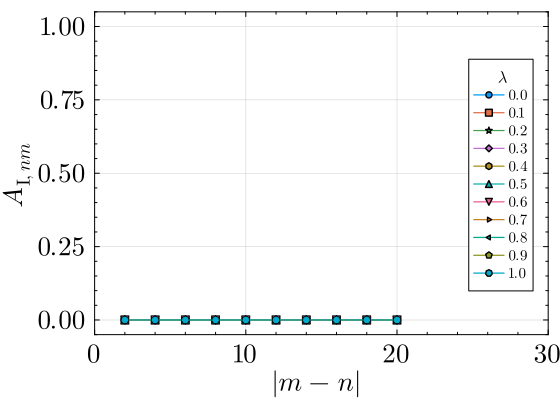

In [52]:
ylbl = "\$ A_{\\textrm{I}, nm} \$"
xlbl = "\$|m-n|\$"

p = plot(
    xlabel = xlbl,
    ylabel = ylbl,
    xformatter = :latex,
    yformatter = :latex,
    legendtitle = "\$\\lambda\$",
    xticks = [0, 10, 20, 30, 40],
    yticks = [0, 0.25, 0.5, 0.75, 1.0],
    xminorticks = 5,
    yminorticks = 5,
    xlim = (0, 30),
    ylim = (-0.05, 1.05),
    framestyle = :box,
    legend = :right,
    xtickfontsize = 18,
    ytickfontsize = 18,
    xguidefontsize = 18,
    yguidefontsize = 18,
    legendfontsize = 10
)

for i in 1:length(strong_state_list)
    λ = λlist[i]
    lbl = "\$$λ\$"
    plot!(
        p,
        distance[i][2:end], abs.(ZZ1[i])[2:end],
        label = lbl,
        markershape = mshapes[i]
    )
end

savefig(p, "./images/a1.pdf")
display(p)

### AII correlator

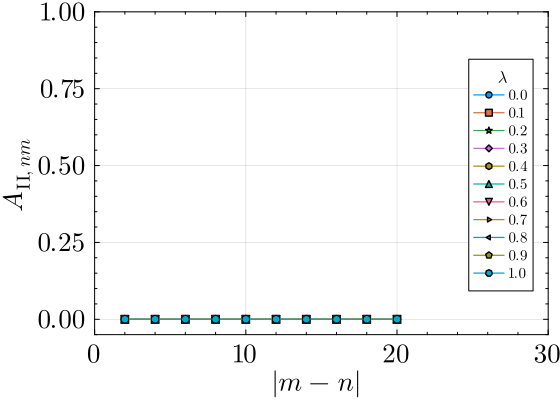

In [53]:
# Label definitions for axis with LaTeX formatting
ylbl = "\$ A_{\\textrm{II}, nm} \$"
xlbl = "\$|m-n|\$"

# Tick marks
yticks = [0, 0.25, 0.5, 0.75, 1.0]
xticks = [0, 10, 20, 30, 40]

# Initialize the plot
p = plot(
    xlabel = xlbl,
    ylabel = ylbl,
    xformatter = :latex,
    yformatter = :latex,
    legendtitle = "\$\\lambda\$",
    xticks = xticks,
    yticks = yticks,
    xminorticks = 5,
    yminorticks = 5,
    xlim = (0, 30),
    ylim = (-0.05, 1.0),
    framestyle = :box,
    legend = :right,
    xtickfontsize = 18,
    ytickfontsize = 18,
    xguidefontsize = 18,
    yguidefontsize = 18,
    legendfontsize = 10
)

# Plot the two-point connected ZZ correlator (A_{II}) for each λ
for i in 1:length(strong_state_list)
    λ = λlist[i]
    lbl = "\$$λ\$"
    plot!(
        p,
        abs.(distance[i])[2:end],
        abs.(ZZ2[i])[2:end],
        label = lbl,
        markershape = mshapes[i]
    )
end

# Optionally save the plot
# savefig(p, "./images/a2.pdf")

# Display the plot
display(p)

### BII correlator

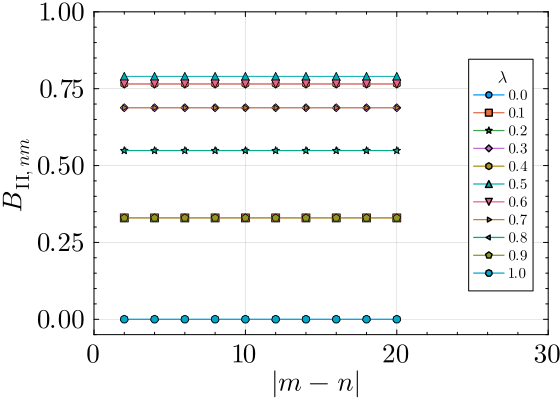

In [54]:
# Axis labels with LaTeX formatting
ylbl = "\$ B_{\\textrm{II}, nm} \$"
xlbl = "\$|m-n|\$"

# Tick values
yticks = [0, 0.25, 0.5, 0.75, 1.0]
xticks = [0, 10, 20, 30, 40]

# Initialize the plot
p = plot(
    xlabel = xlbl,
    ylabel = ylbl,
    xformatter = :latex,
    yformatter = :latex,
    legendtitle = "\$\\lambda\$",
    xticks = xticks,
    yticks = yticks,
    xminorticks = 5,
    yminorticks = 5,
    xlim = (0, 30),
    ylim = (-0.05, 1.0),
    framestyle = :box,
    legend = :right,
    xtickfontsize = 18,
    ytickfontsize = 18,
    xguidefontsize = 18,
    yguidefontsize = 18,
    legendfontsize = 10
)

# Plot the four-point ZZ-ZZ correlator for each λ
for i in 1:length(strong_state_list)
    λ = λlist[i]
    lbl = "\$$λ\$"
    plot!(
        p,
        abs.(distance[i])[2:end],
        abs.(ZZZZ[i])[2:end],
        label = lbl,
        markershape = mshapes[i]
    )
end

# Optionally save the figure
savefig(p, "./images/b2.pdf")

# Display the plot
display(p)